In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
from kmodes.kmodes import KModes
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from collections import Counter
import umap.umap_ as umap
import seaborn as sns

Считываем подготовленный датасет

In [172]:
df = pd.read_csv('Result_26_5.csv', encoding='')
missing_count = df.isna().sum()
print(missing_count)
df.head()

profile_id          0
profile_is_child    0
geo                 0
product_ids         0
device              0
delta               0
positive            0
negative            0
genres              0
hashtags            0
cls                 0
starts              0
versions            0
dtype: int64


,profile_id,profile_is_child,geo,product_ids,device,delta,positive,negative,genres,hashtags,cls,starts,versions
0,6ce3b6b5-280f-4c81-9016-5ec7771202cb,0,RU,"['4f9d83d3-f99e-4f19-80cd-38ff133122ad', 'f3b4...","['mobile', 'mobile', 'mobile', 'mobile', 'mobi...",11963194,0,0,"['drama', 'youth', 'thriller', 'drama', 'youth...","['Молодые и дерзкие', 'Короткометражное кино',...","['Movie', 'Series', 'Series', 'Movie', 'Movie']","['2023-08-27 19:04:12', '2023-08-23 20:40:51',...","['2023-08-27 19:25:53', '2023-08-23 21:56:20',..."
1,a0d47245-6240-4b04-b189-6226b1569eb2,0,RU,['4f819e7c-6384-433e-9184-e793b8d7d82a'],['web'],9402,0,0,"['thriller', 'drama']","['Москва крупным планом', 'Интриги', 'Манипуля...",['Series'],['2024-05-31 17:22:26'],['2024-05-31 17:27:53']
2,18cde70f-00e0-422d-b1ea-57a639615255,0,RU,"['94f12d99-78bf-4785-9b8f-e6eb338abfe9', 'c0c4...","['tv', 'tv', 'tv', 'tv', 'tv', 'tv', 'tv', 'tv...",503510604,0,0,"['melodrama', 'drama', 'comedy', 'family', 'me...","['Нездоровые отношения', 'Звездный актерский с...","['Movie', 'Series', 'Series', 'Series', 'Movie...","['2025-04-27 13:29:52', '2025-04-07 10:16:27',...","['2025-04-27 13:29:52', '2025-04-07 10:16:27',..."
3,476fb1b6-8814-4c33-b154-bce5b7352bd6,1,RU,['1564d800-1fb2-452b-82ee-6b4c88672b9e'],['tv'],5948100,0,0,"['entertainment', 'education', 'talkshow']","['Суперхиты', 'Дружная семья', 'Про дружбу', '...",['Series'],['2023-08-20 11:27:41'],['2023-08-20 13:06:20']
4,70e5db19-435a-4125-b820-7181b4462548,0,DE,"['608da742-46c3-4a5d-8134-532fd391a456', '9eb1...","['mobile', 'mobile', 'tv', 'mobile', 'mobile',...",169830607,0,0,"['detective', 'drama', 'drama', 'comedy', 'dra...","['Ведется расследование', 'Мрачная атмосфера',...","['Series', 'Series', 'Series', 'Series', 'Movi...","['2024-01-20 17:55:21', '2024-01-07 09:58:57',...","['2024-01-20 19:42:06', '2024-01-07 10:34:05',..."


In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2012 entries, 0 to 2011
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   profile_id        2012 non-null   object
 1   profile_is_child  2012 non-null   int64 
 2   geo               2012 non-null   object
 3   product_ids       2012 non-null   object
 4   device            2012 non-null   object
 5   delta             2012 non-null   int64 
 6   positive          2012 non-null   int64 
 7   negative          2012 non-null   int64 
 8   genres            2012 non-null   object
 9   hashtags          2012 non-null   object
 10  cls               2012 non-null   object
 11  starts            2012 non-null   object
 12  versions          2012 non-null   object
dtypes: int64(4), object(9)
memory usage: 204.5+ KB


Анализ датасета

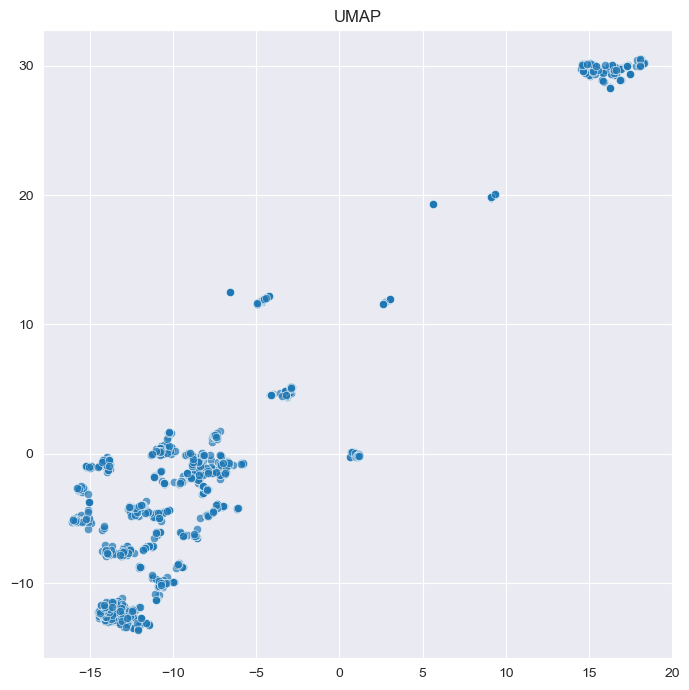

In [174]:
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(df)
reducer = umap.UMAP()
X_umap = reducer.fit_transform(X_encoded)


plt.figure(figsize=(7, 7))
sns.scatterplot(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    alpha=0.7
)
plt.title('UMAP')
plt.tight_layout()
plt.show()

Из графика видно, что точки образуют кластеры, это может указывать на то, что есть группы объектов, которые имеют схожие характеристики.

## Подготовка данных
Бинаризация

In [175]:
def most_frequent(row):        
    counts = Counter(row)
    return [index for index, value in zip(counts.keys(), counts.values()) if value == max(counts.values())]

def data_binarize(series):
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(series)
    return pd.DataFrame(encoded, columns=mlb.classes_)

def time_of_day(h):
    if 5 <= h < 11: return 'Morning'
    elif 11 <= h < 17: return 'Day'
    elif 17 <= h < 23: return 'Evening'
    else: return 'Night'

classes = df['cls'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
classes_df = data_binarize(classes.apply(most_frequent))

devices = df['device'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
devices_df = data_binarize(devices.apply(most_frequent))

starts = df['starts'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

times_of_day = starts.apply(
    lambda times: [time_of_day(pd.to_datetime(t, format='%Y-%m-%d %H:%M:%S', errors='coerce').hour) for t in times if t]
)
period_df = data_binarize(times_of_day.apply(most_frequent))

weekdays = starts.apply(
    lambda times: [
        'weekend' if pd.to_datetime(t, format='%Y-%m-%d %H:%M:%S', errors='coerce').weekday() in [5, 6] else 'weekdays'
        for t in times if t
    ]
)
weekdays_df = data_binarize(weekdays.apply(most_frequent))

genres = df['genres'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
genres_df = data_binarize(genres.apply(most_frequent))

X = pd.concat([
    df['profile_is_child'].fillna(0).astype(int),
    devices_df,
    weekdays_df,
    # period_df,
    genres_df
], axis=1)
X.head()


,profile_is_child,mobile,tv,web,weekdays,weekend,action,adventure,bio,cartoon,...,melodrama,music,mystic,nurseryrhymes,scifi,sport,talkshow,thriller,war,youth
0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


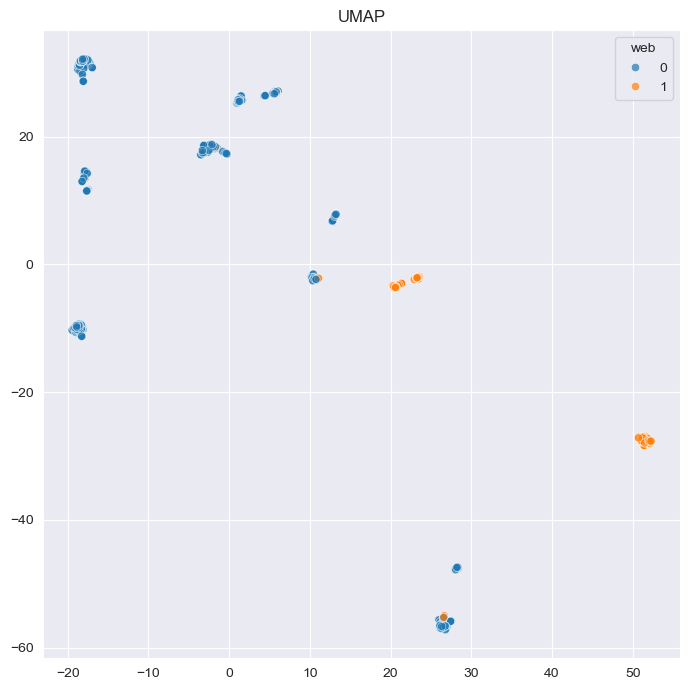

In [176]:
reducer = umap.UMAP()
X_umap = reducer.fit_transform(X)


plt.figure(figsize=(7, 7))
sns.scatterplot(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    hue=X['web'],
    alpha=0.7
)
plt.title('UMAP')
plt.tight_layout()
plt.show()

## Определяем количество кластеров

### Метод локтя

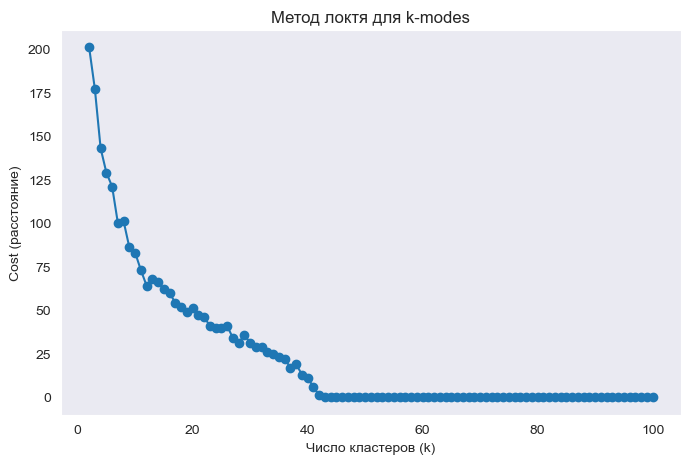

In [170]:
costs = []
K = range(2, 101)
for k in K:
    km = KModes(n_clusters=k, init='Huang', n_init=2, verbose=0, random_state=42, n_jobs=-1)
    clusters = km.fit_predict(X.head(100))
    costs.append(km.cost_)
plt.figure(figsize=(8, 5))
plt.plot(K, costs, marker='o')
plt.xlabel('Число кластеров (k)')
plt.ylabel('Cost (расстояние)')
plt.title('Метод локтя для k-modes')
plt.grid()
plt.show()

In [167]:
km = KModes(n_clusters=43, init='Huang', n_init=5, n_jobs=-1)
clusters = km.fit_predict(X)
df['k_modes_clusters'] = clusters
df.head(1000)

,profile_id,profile_is_child,geo,product_ids,device,delta,positive,negative,genres,hashtags,cls,starts,versions,k_modes_clusters
0,6ce3b6b5-280f-4c81-9016-5ec7771202cb,0,RU,"['4f9d83d3-f99e-4f19-80cd-38ff133122ad', 'f3b4...","['mobile', 'mobile', 'mobile', 'mobile', 'mobi...",11963194,0,0,"['drama', 'youth', 'thriller', 'drama', 'youth...","['Молодые и дерзкие', 'Короткометражное кино',...","['Movie', 'Series', 'Series', 'Movie', 'Movie']","['2023-08-27 19:04:12', '2023-08-23 20:40:51',...","['2023-08-27 19:25:53', '2023-08-23 21:56:20',...",22
1,a0d47245-6240-4b04-b189-6226b1569eb2,0,RU,['4f819e7c-6384-433e-9184-e793b8d7d82a'],['web'],9402,0,0,"['thriller', 'drama']","['Москва крупным планом', 'Интриги', 'Манипуля...",['Series'],['2024-05-31 17:22:26'],['2024-05-31 17:27:53'],4
2,18cde70f-00e0-422d-b1ea-57a639615255,0,RU,"['94f12d99-78bf-4785-9b8f-e6eb338abfe9', 'c0c4...","['tv', 'tv', 'tv', 'tv', 'tv', 'tv', 'tv', 'tv...",503510604,0,0,"['melodrama', 'drama', 'comedy', 'family', 'me...","['Нездоровые отношения', 'Звездный актерский с...","['Movie', 'Series', 'Series', 'Series', 'Movie...","['2025-04-27 13:29:52', '2025-04-07 10:16:27',...","['2025-04-27 13:29:52', '2025-04-07 10:16:27',...",24
3,476fb1b6-8814-4c33-b154-bce5b7352bd6,1,RU,['1564d800-1fb2-452b-82ee-6b4c88672b9e'],['tv'],5948100,0,0,"['entertainment', 'education', 'talkshow']","['Суперхиты', 'Дружная семья', 'Про дружбу', '...",['Series'],['2023-08-20 11:27:41'],['2023-08-20 13:06:20'],2
4,70e5db19-435a-4125-b820-7181b4462548,0,DE,"['608da742-46c3-4a5d-8134-532fd391a456', '9eb1...","['mobile', 'mobile', 'tv', 'mobile', 'mobile',...",169830607,0,0,"['detective', 'drama', 'drama', 'comedy', 'dra...","['Ведется расследование', 'Мрачная атмосфера',...","['Series', 'Series', 'Series', 'Series', 'Movi...","['2024-01-20 17:55:21', '2024-01-07 09:58:57',...","['2024-01-20 19:42:06', '2024-01-07 10:34:05',...",22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,690bed26-1aaa-46b0-82a6-f311b525627f,0,RU,"['aa3c83f0-158b-445e-a4e2-630eeabd9a1a', 'aa3c...","['web', 'web']",6705736,4,5,"['criminal', 'drama', 'criminal', 'drama']","['Необычно снято', 'Острый сюжет', 'Криминальн...","['Series', 'Series']","['2024-01-28 23:51:55', '2024-01-28 23:51:55']","['2024-01-29 00:47:55', '2024-01-29 00:03:41']",18
996,d6f0b083-ca9c-44ba-bd48-23c3208b0332,0,RU,"['b315e3c5-da4b-4dc7-bc01-62d7761e732d', 'b315...","['tv', 'tv']",44546226,0,0,"['drama', 'drama']","['Звездный актерский состав', 'Советское время...","['Series', 'Series']","['2023-11-25 17:47:58', '2023-11-25 17:47:58']","['2023-11-25 18:14:44', '2023-11-25 18:14:44']",5
997,89369e9f-ce20-431b-bf80-b69c85b1b151,0,GB,"['608da742-46c3-4a5d-8134-532fd391a456', 'a94e...","['tv', 'tv', 'tv', 'tv', 'tv', 'tv', 'tv', 'tv...",161662359,0,0,"['detective', 'drama', 'comedy', 'detective', ...","['Ведется расследование', 'Мрачная атмосфера',...","['Series', 'Movie', 'Series', 'Series', 'Serie...","['2023-07-09 17:31:09', '2024-04-27 20:13:09',...","['2023-07-09 17:55:18', '2024-04-27 20:13:09',...",31
998,ce0c36b2-803d-4c5c-9429-bc74f43c4ac4,0,RU,['b315e3c5-da4b-4dc7-bc01-62d7761e732d'],['web'],44839654,0,0,['drama'],"['Звездный актерский состав', 'Советское время...",['Series'],['2024-02-18 13:17:43'],['2024-02-18 15:59:22'],18


In [168]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
s_score = silhouette_score(X, clusters, metric='hamming')
s_score

0.7100484116302179

In [169]:
# from sklearn.metrics import silhouette_score
# 
# s_scores = []
# 
# for k in K:
#     km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0, random_state=42)
#     clusters = km.fit_predict(X.head(50))
#     labels = km.labels_
#     print(labels)
#     score = silhouette_score(X.head(50), labels)
#     s_scores.append(score)
# plt.plot(K, s_scores, 'bo-')
# plt.xlabel('Количество кластеров')
# plt.ylabel('Silhouette score')
# plt.show()